In [1]:
import os

Origin_Good = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Bad_Pictures'
Origin_Bad = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Good_Pictures'



In [2]:
#Step One: Image Preprocessing

from PIL import Image


def Convert_Grayscale(Origin_Path, Destination_Path):

#Check for existing Folder Othervise Create them
  if not os.path.exists(Destination_Path):
    os.makedirs(Destination_Path)

    print("Warning, Destination Folder Does not Exist, Creating it for you...")

  for filename in os.listdir(Origin_Path):
    if filename.endswith(('.jpg', 'jpeg', 'png', 'bmp', 'tiff', 'gif')):
      image_path = os.path.join(Origin_Path, filename)
      img = Image.open(image_path).convert('L')

      output_path = os.path.join(Destination_Path, filename)
      img.save(output_path)

  print("Conversion Complete")

Good_Grayscale = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Bad_Pictures_Grayscale'
Bad_Grayscale = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Good_Pictures_Grayscale'

Convert_Grayscale(Origin_Good, Good_Grayscale)
Convert_Grayscale(Origin_Bad, Bad_Grayscale)

Conversion Complete
Conversion Complete


In [ ]:
#Step Two Train Test Split

import shutil
from sklearn.model_selection import train_test_split


def split_data(source,test,train,test_size=0.2):

  if not os.path.exists(train):
    os.makedirs(train)

    print("Warning, train Destination Folder Does not Exist, Creating it for you...")

  if not os.path.exists(test):
    os.makedirs(test)

    print("Warning, test Destination Folder Does not Exist, Creating it for you...")

  #Iterate through the folder and add anything to the list, that is a File and not a folder
  files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]

  #If folder is Empty
  if len(files) == 0:
    print("Der Ordner ist Leer")
    return
  

  #Actual Split
  train_files, test_files = train_test_split(files,test_size = test_size,random_state=36)

  #Debug
  #print(len(train_files))
  #print(train_files)
  #print(len(test_files))
  #print(test_files)

  #Copying of the files "os.XXX" for Joining the Path and filename to the element in the train files list
  #Coping from first path to last path with soutil function
  for file in train_files:
    shutil.move(os.path.join(source,file),os.path.join(train,file))

  for file in test_files:
    shutil.move(os.path.join(source,file),os.path.join(test,file))

  print(f"Kopieren abgeschlossen. {len(train_files)} Dateien im Trainingsordner, {len(test_files)} Dateien im Testordner.")

#execute Train Test split

test_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Test'
train_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Train'

split_data(Good_Grayscale,test_folder,train_folder)
split_data(Bad_Grayscale,test_folder,train_folder)




Kopieren abgeschlossen. 68 Dateien im Trainingsordner, 17 Dateien im Testordner.
Kopieren abgeschlossen. 168 Dateien im Trainingsordner, 42 Dateien im Testordner.


In [4]:
#execute the Train Test Split again to split the Train Data in Train and Validate

validate_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Validate'

split_data(train_folder,validate_folder,train_folder)

Kopieren abgeschlossen. 188 Dateien im Trainingsordner, 48 Dateien im Testordner.


In [2]:
import os
test_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Test'
train_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Train'

validate_folder = '/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Validate'

In [6]:
# Step Three Image Setup Variables

FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

188 Images
48 Images


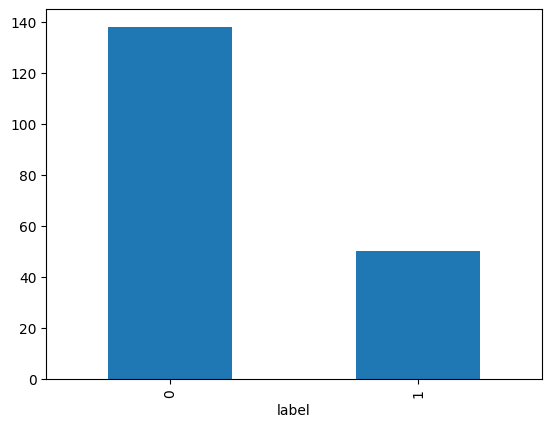

In [5]:
#Step 4 Creating the Dataframe to

import pandas as pd

#Der Pfad muss nochmal als Raw String definiert werden, damit Pandas damit umghehen kann.
filenames = os.listdir(r'/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Train')

def make_df(images):

  labels = []

  for filename in images:
    label = filename.split(' ')[0]
    if label == 'Good':
      labels.append(0)
    else:
      labels.append(1)

  df = pd.DataFrame({'filename': images, 'label': labels})

  return df

df = make_df(filenames)
df_validate = make_df(os.listdir(r'/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Validate'))

df.head(1000)

df['label'].value_counts().plot.bar()

print(len(df),'Images')
print(len(df_validate),'Images')

In [4]:
#Funktion zum Plotten eines Bildes

import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

filepath = r'/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Train/'

def Print_Image(sample):
  image = load_img(filepath+sample)
  plt.imshow(image)

Print_Image(random.choice(filenames))

NameError: name 'filenames' is not defined

In [9]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
#Step 5 Setup of the first ML model

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
#from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def Setup_MobilNet():
  base_model = MobileNet(weights='imagenet', include_top=False) # Importing the Base

  #Setup of the Layers for better Results
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  preds = Dense(2, activation='softmax')(x)

  return base_model, x, preds

base_model, x, preds = Setup_MobilNet()

/var/folders/pb/7bl9_xg50fn7hxpq2dzc36w40000gn/T/ipykernel_25253/1942971395.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False) # Importing the Base


In [11]:
#Step 5.1 First optimizing of the Base Model

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
for layer in model.layers[:20]:
  layer.trainable = False
for layer in model.layers[20:]:
  layer.trainable = True

In [13]:
#Step 5.2 Setup EarlyStop and Learning Rate (Callbacks)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)
callbacks = [earlystop, learning_rate_reduction]

#Regularisierung 

#Renaming the dfs to have Good and Bad as Labels #why not in the first place?
df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'})
df_validate["label"] = df_validate["label"].replace({0: 'Good', 1: 'Bad'})

df = df.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

total_train = df.shape[0]
total_validate = df_validate.shape[0]
batch_size = 15

In [14]:
#Creating the Train data
#Here Try different Options
train_datagen = ImageDataGenerator(
    rotation_range=20, #15
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2, #0.2
    horizontal_flip=True,
    width_shift_range=0.1, #0.1
    height_shift_range=0.1 #0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df,
    filepath,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 188 validated image filenames belonging to 2 classes.


In [15]:
valitation_filepath = r'/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Validate'

#Creating the Validation data

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_validate,
    valitation_filepath,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 48 validated image filenames belonging to 2 classes.


In [16]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - accuracy: 0.5260 - loss: 1.6964 - val_accuracy: 0.6222 - val_loss: 1.2799 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8000 - loss: 0.2803 - val_accuracy: 0.6667 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 3/50


2024-11-08 19:24:42.475739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-08 19:24:42.518821: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - accuracy: 0.8345 - loss: 0.4230 - val_accuracy: 0.8000 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9333 - loss: 0.1987 - val_accuracy: 1.0000 - val_loss: 0.1549 - learning_rate: 0.0010
Epoch 5/50


2024-11-08 19:24:47.112574: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.8996 - loss: 0.3565 - val_accuracy: 0.8667 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 6/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 1.0000 - loss: 0.1454
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1454 - val_accuracy: 0.6667 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.9426 - loss: 0.2500 - val_accuracy: 0.8444 - val_loss: 0.6988 - learning_rate: 5.0000e-04
Epoch 8/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.9333 - loss: 0.0897
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9333 - loss: 0.0897 - val_accuracy: 1.0000 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 9/50


2024-11-08 19:24:56.723238: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.9332 - loss: 0.2059 - val_accuracy: 0.8889 - val_loss: 0.6295 - learning_rate: 2.5000e-04
Epoch 10/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 1.0000 - loss: 0.0263
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 0.3333 - val_loss: 3.8102 - learning_rate: 2.5000e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.9266 - loss: 0.1722 - val_accuracy: 0.8444 - val_loss: 0.8360 - learning_rate: 1.2500e-04
Epoch 12/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 1.0000 - loss: 0.0508
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 8.2961e-04 - learning_rate: 1.2500e-04
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.9654 - loss: 0.1134 - val_ac

2024-11-08 19:25:14.514715: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.9572 - loss: 0.1402 - val_accuracy: 0.8667 - val_loss: 0.4190 - learning_rate: 1.0000e-04
Epoch 18/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 9.6121e-04 - learning_rate: 1.0000e-04
Epoch 19/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9916 - loss: 0.0423 - val_accuracy: 0.8444 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 20/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0377 - val_accuracy: 1.0000 - val_loss: 2.2260e-04 - learning_rate: 1.0000e-04
Epoch 21/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - accuracy: 0.9811 - loss: 0.0454 - val_accuracy: 0.9333 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 22/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9333 - loss: 0.0953 - val_accuracy: 0.6667 - val_loss: 1.4450 - learning_rate: 1.0000e-04
Epoch 23/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.9

2024-11-08 19:25:54.471504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9854 - loss: 0.0287 - val_accuracy: 0.9111 - val_loss: 0.2956 - learning_rate: 1.0000e-04
Epoch 34/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 8.1807e-04 - learning_rate: 1.0000e-04
Epoch 35/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9111 - val_loss: 0.4050 - learning_rate: 1.0000e-04
Epoch 36/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 37/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.9953 - loss: 0.0312 - val_accuracy: 0.9111 - val_loss: 0.2086 - learning_rate: 1.0000e-04
Epoch 38/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 39/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.9911 

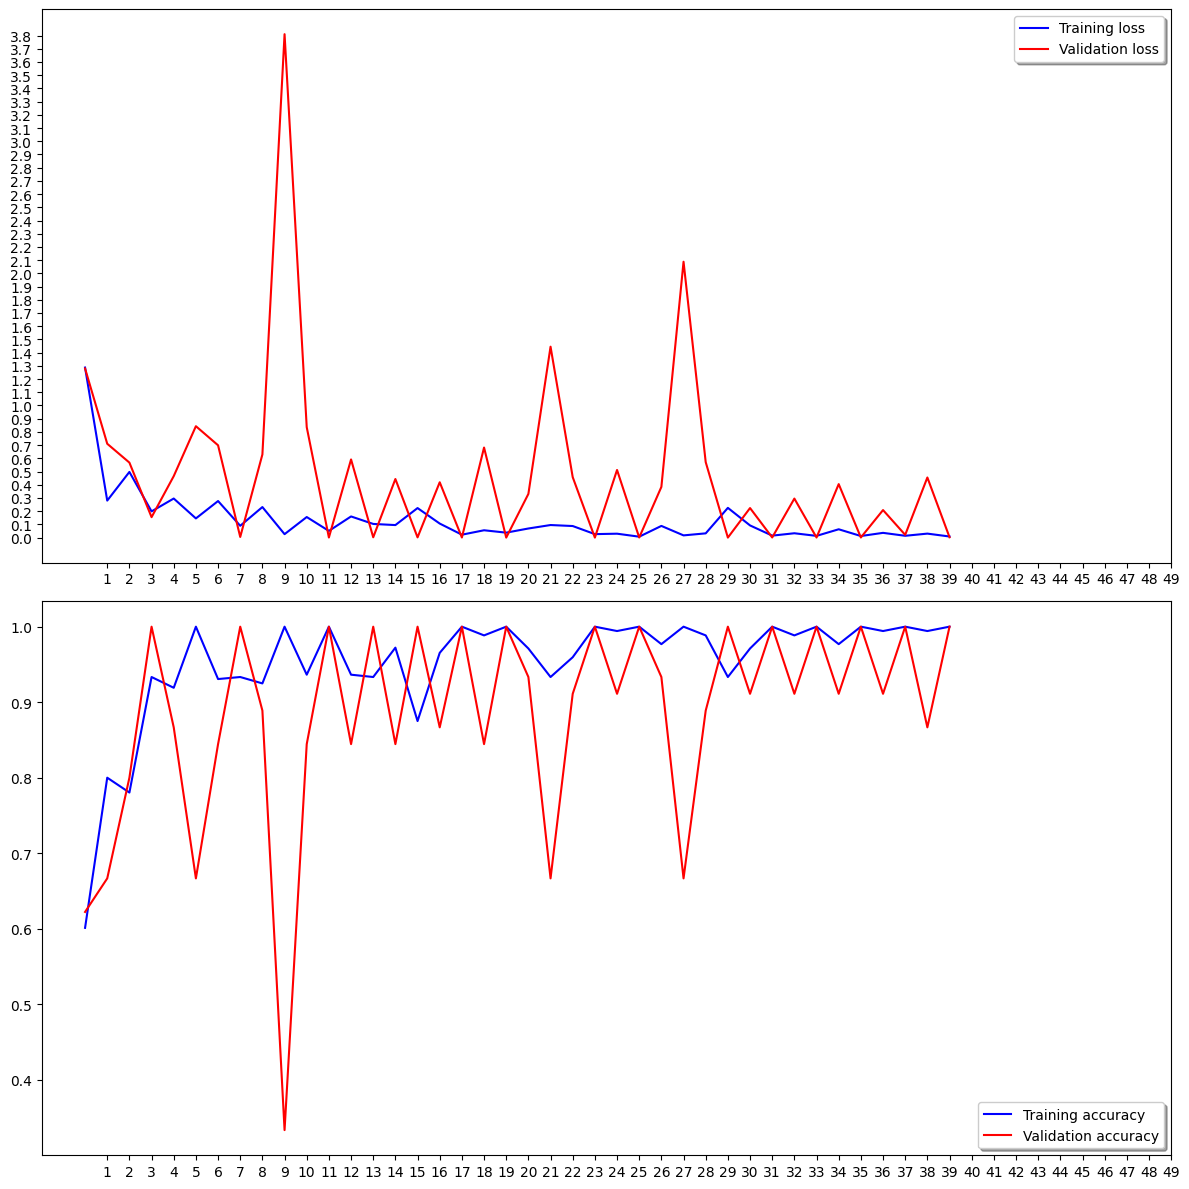

In [17]:
#Plotting the Loss and Accuracy

import numpy as np

def Plot_Loss_Accuracy(history):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
  ax1.plot(history.history['loss'], color='b', label="Training loss")
  ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
  ax1.set_xticks(np.arange(1, epochs, 1))
  ax1.set_yticks(np.arange(0, max(max(history.history['loss']),max(history.history['val_loss'])), 0.1))
  ax1.legend(loc="upper right", shadow=True)

  ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  ax2.set_xticks(np.arange(1, epochs, 1))
  ax2.legend(loc="lower right", shadow=True)

  plt.tight_layout()
  plt.show()


Plot_Loss_Accuracy(history)

In [ ]:
#Saving the Model

model.save_weights(".weights.h5")
model.save("/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/results/.weights.h5") #hier noch optimieren

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(r"/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/results/.weights.h5")

In [20]:
#step 6 Test all of this

test_filepath = r"/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/Test"



def Test_Model(test_folder, test_filepath):
  test_filenames = os.listdir(test_filepath)
  test_df = pd.DataFrame({'filename': test_filenames})
  nb_samples = test_df.shape[0]

  test_gen = ImageDataGenerator(rescale=1./255)
  test_generator = test_gen.flow_from_dataframe(
    test_df,
    test_filepath,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
  )
  steps=np.ceil(nb_samples/batch_size)

  print("Test generator output shape:", next(test_generator)[0].shape)  # Form eines Batches aus dem Generator

  predict = model.predict(test_generator, steps= int(np.ceil(nb_samples/batch_size)))

  test_df['label'] = np.argmax(predict, axis=-1)

  label_map = dict((v,k) for k,v in train_generator.class_indices.items())
  test_df['label'] = test_df['label'].replace(label_map)

  return test_df

test_df = Test_Model(test_folder, test_filepath)


Found 59 validated image filenames.
Test generator output shape: (224, 224, 3)


2024-11-08 19:26:14.127011: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32,), but the yielded element was [[[[0.9960785  0.9960785  0.9960785 ]
   [0.9921569  0.9921569  0.9921569 ]
   [0.97647065 0.97647065 0.97647065]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9843138  0.9843138  0.9843138 ]]

  [[0.91372555 0.91372555 0.91372555]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.83921576 0.83921576 0.83921576]
   [0.8980393  0.8980393  0.8980393 ]
   [1.         1.         1.        ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  ...

  [[1.         1.         1.      

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32,), but the yielded element was [[[[0.9960785  0.9960785  0.9960785 ]
   [0.9921569  0.9921569  0.9921569 ]
   [0.97647065 0.97647065 0.97647065]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9843138  0.9843138  0.9843138 ]]

  [[0.91372555 0.91372555 0.91372555]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.83921576 0.83921576 0.83921576]
   [0.8980393  0.8980393  0.8980393 ]
   [1.         1.         1.        ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.89019614 0.89019614 0.89019614]
   [0.95294124 0.95294124 0.95294124]
   [0.7960785  0.7960785  0.7960785 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.94117653 0.94117653 0.94117653]
   [1.         1.         1.        ]
   [0.8313726  0.8313726  0.8313726 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.97647065 0.97647065 0.97647065]]

  [[0.97647065 0.97647065 0.97647065]
   [0.9843138  0.9843138  0.9843138 ]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.78823537 0.78823537 0.78823537]
   [0.79215693 0.79215693 0.79215693]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.79215693 0.79215693 0.79215693]
   [0.78823537 0.78823537 0.78823537]
   [0.97647065 0.97647065 0.97647065]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.75294125 0.75294125 0.75294125]
   [0.8196079  0.8196079  0.8196079 ]
   [0.9960785  0.9960785  0.9960785 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 ...


 [[[0.30588236 0.30588236 0.30588236]
   [0.33333334 0.33333334 0.33333334]
   [0.5137255  0.5137255  0.5137255 ]
   ...
   [0.5686275  0.5686275  0.5686275 ]
   [0.63529414 0.63529414 0.63529414]
   [0.60784316 0.60784316 0.60784316]]

  [[0.30980393 0.30980393 0.30980393]
   [0.32941177 0.32941177 0.32941177]
   [0.5372549  0.5372549  0.5372549 ]
   ...
   [0.68235296 0.68235296 0.68235296]
   [0.654902   0.654902   0.654902  ]
   [0.6862745  0.6862745  0.6862745 ]]

  [[0.3254902  0.3254902  0.3254902 ]
   [0.3137255  0.3137255  0.3137255 ]
   [0.7803922  0.7803922  0.7803922 ]
   ...
   [0.7019608  0.7019608  0.7019608 ]
   [0.61960787 0.61960787 0.61960787]
   [0.6        0.6        0.6       ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.9686275  0.9686275  0.9686275 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.86666673 0.86666673 0.86666673]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.75294125 0.75294125 0.75294125]
   [0.9803922  0.9803922  0.9803922 ]
   [0.7294118  0.7294118  0.7294118 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.9803922  0.9803922  0.9803922 ]
   [0.909804   0.909804   0.909804  ]
   [0.9607844  0.9607844  0.9607844 ]]]


 [[[1.         1.         1.        ]
   [0.92549026 0.92549026 0.92549026]
   [0.9803922  0.9803922  0.9803922 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9215687  0.9215687  0.9215687 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.7568628  0.7568628  0.7568628 ]
   [0.91372555 0.91372555 0.91372555]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.49803925 0.49803925 0.49803925]
   [0.47058827 0.47058827 0.47058827]
   [0.42352945 0.42352945 0.42352945]]

  [[0.45098042 0.45098042 0.45098042]
   [0.8862746  0.8862746  0.8862746 ]
   [0.6431373  0.6431373  0.6431373 ]
   ...
   [0.46274513 0.46274513 0.46274513]
   [0.4901961  0.4901961  0.4901961 ]
   [0.46274513 0.46274513 0.46274513]]

  [[0.4431373  0.4431373  0.4431373 ]
   [0.4039216  0.4039216  0.4039216 ]
   [0.93725497 0.93725497 0.93725497]
   ...
   [0.49411768 0.49411768 0.49411768]
   [0.49803925 0.49803925 0.49803925]
   [0.46274513 0.46274513 0.46274513]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.5411765  0.5411765  0.5411765 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.6745098  0.6745098  0.6745098 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.5372549  0.5372549  0.5372549 ]
   [0.98823535 0.98823535 0.98823535]
   [0.6156863  0.6156863  0.6156863 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.77647066 0.77647066 0.77647066]
   [0.9058824  0.9058824  0.9058824 ]
   [0.61960787 0.61960787 0.61960787]]]].
Traceback (most recent call last):

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1414, in _tf_data_assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: 'ndarray'.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/andreasbraig/Documents/VSCode/ML-Project/ML-Project-Festo/ML-Project/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32,), but the yielded element was [[[[0.9960785  0.9960785  0.9960785 ]
   [0.9921569  0.9921569  0.9921569 ]
   [0.97647065 0.97647065 0.97647065]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9843138  0.9843138  0.9843138 ]]

  [[0.91372555 0.91372555 0.91372555]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.83921576 0.83921576 0.83921576]
   [0.8980393  0.8980393  0.8980393 ]
   [1.         1.         1.        ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.89019614 0.89019614 0.89019614]
   [0.95294124 0.95294124 0.95294124]
   [0.7960785  0.7960785  0.7960785 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.94117653 0.94117653 0.94117653]
   [1.         1.         1.        ]
   [0.8313726  0.8313726  0.8313726 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.97647065 0.97647065 0.97647065]]

  [[0.97647065 0.97647065 0.97647065]
   [0.9843138  0.9843138  0.9843138 ]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.78823537 0.78823537 0.78823537]
   [0.79215693 0.79215693 0.79215693]
   [0.9607844  0.9607844  0.9607844 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.79215693 0.79215693 0.79215693]
   [0.78823537 0.78823537 0.78823537]
   [0.97647065 0.97647065 0.97647065]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.75294125 0.75294125 0.75294125]
   [0.8196079  0.8196079  0.8196079 ]
   [0.9960785  0.9960785  0.9960785 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 ...


 [[[0.30588236 0.30588236 0.30588236]
   [0.33333334 0.33333334 0.33333334]
   [0.5137255  0.5137255  0.5137255 ]
   ...
   [0.5686275  0.5686275  0.5686275 ]
   [0.63529414 0.63529414 0.63529414]
   [0.60784316 0.60784316 0.60784316]]

  [[0.30980393 0.30980393 0.30980393]
   [0.32941177 0.32941177 0.32941177]
   [0.5372549  0.5372549  0.5372549 ]
   ...
   [0.68235296 0.68235296 0.68235296]
   [0.654902   0.654902   0.654902  ]
   [0.6862745  0.6862745  0.6862745 ]]

  [[0.3254902  0.3254902  0.3254902 ]
   [0.3137255  0.3137255  0.3137255 ]
   [0.7803922  0.7803922  0.7803922 ]
   ...
   [0.7019608  0.7019608  0.7019608 ]
   [0.61960787 0.61960787 0.61960787]
   [0.6        0.6        0.6       ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.9686275  0.9686275  0.9686275 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.86666673 0.86666673 0.86666673]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.75294125 0.75294125 0.75294125]
   [0.9803922  0.9803922  0.9803922 ]
   [0.7294118  0.7294118  0.7294118 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.9803922  0.9803922  0.9803922 ]
   [0.909804   0.909804   0.909804  ]
   [0.9607844  0.9607844  0.9607844 ]]]


 [[[1.         1.         1.        ]
   [0.92549026 0.92549026 0.92549026]
   [0.9803922  0.9803922  0.9803922 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9215687  0.9215687  0.9215687 ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]]


 [[[0.7568628  0.7568628  0.7568628 ]
   [0.91372555 0.91372555 0.91372555]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.49803925 0.49803925 0.49803925]
   [0.47058827 0.47058827 0.47058827]
   [0.42352945 0.42352945 0.42352945]]

  [[0.45098042 0.45098042 0.45098042]
   [0.8862746  0.8862746  0.8862746 ]
   [0.6431373  0.6431373  0.6431373 ]
   ...
   [0.46274513 0.46274513 0.46274513]
   [0.4901961  0.4901961  0.4901961 ]
   [0.46274513 0.46274513 0.46274513]]

  [[0.4431373  0.4431373  0.4431373 ]
   [0.4039216  0.4039216  0.4039216 ]
   [0.93725497 0.93725497 0.93725497]
   ...
   [0.49411768 0.49411768 0.49411768]
   [0.49803925 0.49803925 0.49803925]
   [0.46274513 0.46274513 0.46274513]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.5411765  0.5411765  0.5411765 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.6745098  0.6745098  0.6745098 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.5372549  0.5372549  0.5372549 ]
   [0.98823535 0.98823535 0.98823535]
   [0.6156863  0.6156863  0.6156863 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.77647066 0.77647066 0.77647066]
   [0.9058824  0.9058824  0.9058824 ]
   [0.61960787 0.61960787 0.61960787]]]].


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 